In [1]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.111.0
    Uninstalling fastapi-0.111.0:
      Successfully uninstalled fastapi-0.111.0


In [2]:
import gradio as gr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Image and map dimensions
row,col=240,320
row_gt, col_gt = 30, 40
last_freeze_layer = 23 #according to VGG16 and model architecture
prior_size = (row_gt // 10, col_gt // 10)

############ Datasets ###########

#use this to train and test on SALICON
imgs_train_path = '/kaggle/input/salicon-mini/images/train/'
maps_train_path = '/kaggle/input/salicon-mini/maps/train/'
# imgs_val_path = '/kaggle/input/salicon-mini/images/val/'
# maps_val_path = '/kaggle/input/salicon-mini/maps/val/'
# imgs_test_path = '/kaggle/input/salicon-mini/images/test/'


#use this to train and test on UI dataset - 1s heatmap
# imgs_train_path='/kaggle/input/my-ui-dataset/images/images/'
# maps_train_path = '/kaggle/input/my-ui-dataset/heatmaps_1s/heatmaps_1s - Copy/'
# imgs_test_path = '/kaggle/input/salicon-mini/images/test/'


#use this to train and test on UI dataset - 3s heatmap
# imgs_train_path='/kaggle/input/my-ui-dataset/images/images/'
# maps_train_path = '/kaggle/input/my-ui-dataset/heatmaps_3s/heatmaps_3s/'
# imgs_test_path = '/kaggle/input/salicon-mini/images/test/'


#use this to train and test on UI dataset - 7s heatmap
# imgs_train_path='/kaggle/input/my-ui-dataset/images/images/'
# maps_train_path = '/kaggle/input/my-ui-dataset/heatmaps_7s/heatmaps_7s/'
# imgs_test_path = '/kaggle/input/salicon-mini/images/test/'




####################
# imgs_train_path = '/kaggle/input/my-ui-dataset/images/images/'
# maps_train_path = '/kaggle/input/my-ui-dataset/heatmaps_7s/heatmaps_7s/'
imgs_val_path = '/kaggle/input/my-ui-dataset/images/images/'
maps_val_path = '/kaggle/input/my-ui-dataset/heatmaps_7s/heatmaps_7s/'
# imgs_val_path = '/kaggle/input/salicon-mini/images/val/'
# maps_val_path = '/kaggle/input/salicon-mini/maps/val/'
imgs_test_path = '/kaggle/input/salicon-mini/images/test/'

In [4]:
# Padding function - to maintain aspect ratio
def img_padding(img, shape_r=480, shape_c=640, channels=3):
    original_shape = img.shape
    if channels == 1:    #for gray scale image/maps
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)
    else:
        img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)
    
    rows_ratio,cols_ratio=original_shape[0]/shape_r,original_shape[1]/shape_c
    
    if rows_ratio > cols_ratio:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r)) 
        img_padded[:,(shape_c-min(new_cols, shape_c))//2 : (shape_c + min(new_cols, shape_c))//2] = img
    else:
        new_rows=(original_shape[0]*shape_c)//original_shape[1]
        img = cv2.resize(img,(shape_c, new_rows))
        img_padded[(shape_r-min(new_rows,shape_r))//2 : (shape_r+min(new_rows,shape_r))//2, :] = img
    return img_padded

#Preprocessing functions
def preprocess_images(paths,shape_r,shape_c):
    imgs=np.zeros((len(paths), shape_r, shape_c, 3))
    for i, path in enumerate(paths):
        imgs[i] = img_padding(cv2.imread(path), shape_r, shape_c, 3).astype('float')
    imgs=imgs[..., ::-1]/255.0  # Convert to RGB and normalize
    return np.rollaxis(imgs,3,1)  # Convert to pytorch representation from numpy

def preprocess_maps(paths,shape_r,shape_c):
    maps=np.zeros((len(paths), 1, shape_r, shape_c))
    for i, path in enumerate(paths):
        maps[i,0] = img_padding(cv2.imread(path, 0),shape_r,shape_c,1).astype(np.float32) / 255.0
    return maps

# Data generator
def generator(batch_size,data_type='train'):
    if data_type == 'train':
        images = [imgs_train_path + f for f in os.listdir(imgs_train_path) if f.endswith(('.jpg','.png'))]
        maps = [maps_train_path + f for f in os.listdir(maps_train_path) if f.endswith(('.jpg','.png'))]
    elif data_type == 'val':
        images = [imgs_val_path + f for f in os.listdir(imgs_val_path) if f.endswith(('.jpg','.png'))]
        maps = [maps_val_path + f for f in os.listdir(maps_val_path) if f.endswith(('.jpg','.png'))]
    else:
        ##### for using test images ###########
        images = [imgs_test_path + f for f in os.listdir(imgs_test_path) if f.endswith(('.jpg','.png'))]
        images=shuffle(sorted(images))
        count=0
        while True:
            yield preprocess_images(images[count:count+batch_size],row,col)
            if count+batch_size >=len(images):  #in case it goes beyond num of images
                break
            count += batch_size
    
    images,maps=shuffle(sorted(images), sorted(maps))
    count = 0
    while True:
        yield preprocess_images(images[count:count+batch_size],row,col), preprocess_maps(maps[count:count + batch_size],row_gt,col_gt)
        if count + batch_size >= len(images):   #in case it goes beyond num of images
            break
        count += batch_size

In [5]:
# MLNet definition
class Saliency_MLNet(nn.Module):
    def __init__(self, prior_size):
        super(Saliency_MLNet, self).__init__()
        features = list(models.vgg16(pretrained=True).features)[:-1]
        features[23].stride = 1
        features[23].kernel_size = 5
        features[23].padding = 2
        self.features = nn.ModuleList(features).eval()
        self.fddropout = nn.Dropout2d(p=0.4)
        self.int_conv = nn.Conv2d(1280, 64, kernel_size=3, padding=1)
        self.pre_final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.prior = nn.Parameter(torch.ones((1, 1, prior_size[0], prior_size[1]), requires_grad=True))
        self.bilinearup = torch.nn.UpsamplingBilinear2d(scale_factor=10)

    ########## forward pass ###############
    def forward(self, x):
        results = []
        for i, model in enumerate(self.features):
            x = model(x)
            if i in {16, 23, 29}:
                results.append(x)
        x = torch.cat(results, dim=1)
        x = self.fddropout(x)
        x = self.int_conv(x)
        x = self.pre_final_conv(x)
        upscaled_prior = self.bilinearup(self.prior)
        x *= upscaled_prior
        return torch.relu(x)

In [6]:
########### Loss Definition ###########
class ModMSELoss(nn.Module):
    def __init__(self, shape_r_gt, shape_c_gt):
        super(ModMSELoss, self).__init__()
        self.shape_r_gt, self.shape_c_gt = shape_r_gt, shape_c_gt
        
    def forward(self, output, label, prior):
        prior_size = prior.shape
        output_max = torch.max(output.view(output.size(0), -1), dim=1)[0].view(-1, 1, 1, 1)+1e-7
        reg = (1.0 / (prior_size[0] * prior_size[1])) * (1 - prior)**2
        loss = torch.mean(((output / output_max) - label)**2 / (1 - label + 0.1)) + torch.sum(reg)
        return loss

In [7]:
# # Visualize predictions
# def visualize_predictions(model, generator, num_samples=5):
#     model.eval()
#     images, heatmaps = next(generator(num_samples, phase_gen="val"))
#     with torch.no_grad():
#         batch_imgs = torch.tensor(images, dtype=torch.float32).to(device)
#         predictions = model(batch_imgs).cpu().numpy()
#     for idx in range(num_samples):
#         original_image = np.transpose(images[idx], (1, 2, 0))[..., ::-1]
#         heatmap = predictions[idx, 0]
#         overlay = original_image.copy()
#         heatmap_resized = cv2.resize(heatmap, (shape_c, shape_r))
#         overlay[..., 0] += heatmap_resized * 0.5
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original_image); plt.axis("off")
#         plt.subplot(1, 3, 2); plt.title("Heatmap"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
#         plt.subplot(1, 3, 3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
#         plt.show()

####### Visualizaation to see overlay of saliency map on images #######
def visualize_predictions(model, generator, num_samples=5, alpha=0.55):

    model.eval()
    images= next(generator(num_samples,data_type="test"))
    
    # Move images to device for model prediction
    batch_imgs = torch.tensor(images, dtype=torch.float32).to(device)
    with torch.no_grad():
        predictions = model(batch_imgs).cpu().numpy()
    
    #Loop through images + plot
    for idx in range(num_samples):
        input_image = np.transpose(images[idx], (1, 2, 0))[..., ::-1]  # Convert to HWC and BGR
        input_image = (input_image * 255).astype(np.uint8)  # Denormalize for visualization
        prediction = predictions[idx, 0]
        
        #Resize prediction results to original image shape
        heatmap_resized = cv2.resize(prediction, (input_image.shape[1], input_image.shape[0]))
        heatmap_normalized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) + 1e-8)
        
        #colormap
        saliency_map = plt.cm.inferno(heatmap_normalized)[..., :3]  # Use "inferno" colormap
        blended_image = (alpha * saliency_map + (1 - alpha) * input_image / 255).clip(0, 1)
        
        ####### Plot ##########
        plt.figure(figsize=(12, 6))
        
        ########## Original image
        plt.subplot(1, 3, 1)
        plt.imshow(input_image[..., ::-1])  # Convert to RGB for display
        plt.title("Input Image")
        plt.axis("off")
        
        ########## Only Saliency heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap_normalized, cmap="inferno")
        plt.title("Saliency Heatmap")
        plt.axis("off")
        
        ##### Saliency heatmap overlayed on Input image ######
        plt.subplot(1, 3, 3)
        plt.imshow(blended_image)
        plt.title("Overlayed Saliency Map")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

In [8]:
# Training the model
model = Saliency_MLNet(prior_size).to(device)
for i, param in enumerate(model.parameters()):
    if i<last_freeze_layer:
        param.requires_grad = False

criterion = ModMSELoss(row_gt, col_gt).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size, num_epochs = 32, 2
loss_history = []

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]


Epoch:1 Batch:32 Loss:0.08898146450519562
Epoch:1 Batch:64 Loss:0.0561956912279129
Epoch:1 Batch:96 Loss:0.04889487102627754
Epoch:1 Batch:128 Loss:0.03368213772773743
Time taken for epoch-1 : 1.34m
Average Loss for epoch 1: 0.0569
Epoch:2 Batch:32 Loss:0.03443051502108574
Epoch:2 Batch:64 Loss:0.03259957209229469
Epoch:2 Batch:96 Loss:0.04047715663909912
Epoch:2 Batch:128 Loss:0.03136323019862175
Time taken for epoch-2 : 1.29m
Average Loss for epoch 2: 0.0347


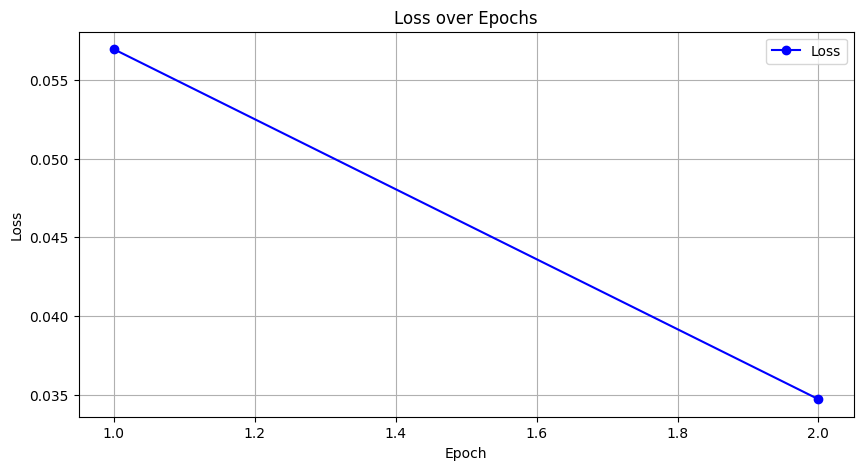

In [9]:
# for epoch in range(num_epochs):
#     t1, epoch_loss = time.time(), 0
#     for batch_imgs, batch_maps in generator(batch_size):
#         optimizer.zero_grad()
#         batch_imgs = torch.tensor(batch_imgs, dtype=torch.float32).to(device)
#         batch_maps = torch.tensor(batch_maps, dtype=torch.float32).to(device)
#         predictions = model(batch_imgs)
#         loss = criterion(predictions, batch_maps, model.prior.clone())
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     loss_history.append(epoch_loss)
#     print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f} Time: {(time.time()-t1)/60:.2f} mins")


for epoch in range(num_epochs):  # Adjust the number of epochs as needed
    t1 = time.time()
    epoch_loss = 0
    image_trained = 0
    num_batches = 0  # Count the number of batches for averaging loss
    
    for (i, gt_map) in generator(batch_size):   ##gets the img and map here
        optimizer.zero_grad()
        (i, gt_map) = (torch.tensor(i.copy(), dtype=torch.float), torch.tensor(gt_map, dtype=torch.float))
        for (idx, x) in enumerate(i):
            i[idx] = normalize(x)
        (i, gt_map) = (i.to(device), gt_map.to(device))
        
        image_trained += batch_size
        num_batches += 1
        
        # Forward pass and loss calculation
        out = model.forward(i)
        loss = criterion(out, gt_map, model.prior.to(device))
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        print('Epoch:{} Batch:{} Loss:{}'.format(epoch + 1, image_trained, loss.item()))
    
    # Log average loss for the epoch
    avg_loss = epoch_loss / num_batches
    loss_history.append(avg_loss)
    
    t2 = time.time()
    time_per_epoch = (t2 - t1) / 60.0
    print('Time taken for epoch-{} : {:.2f}m'.format(epoch + 1, time_per_epoch))
    print('Average Loss for epoch {}: {:.4f}'.format(epoch + 1, avg_loss))


# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', color='b', label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

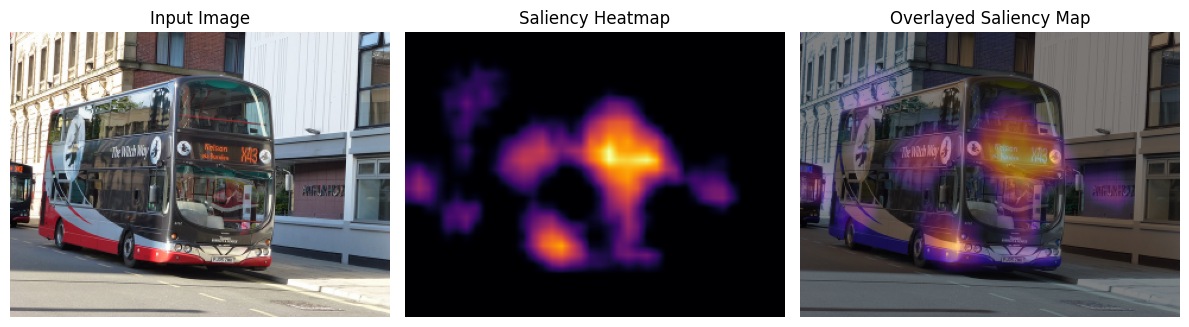

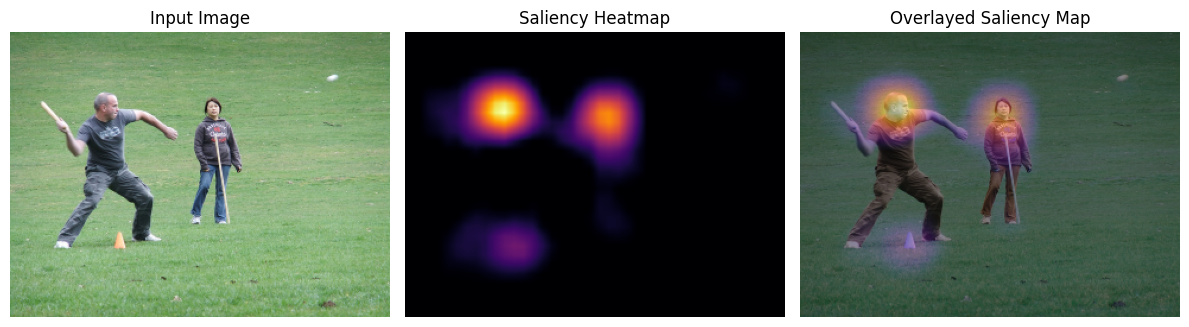

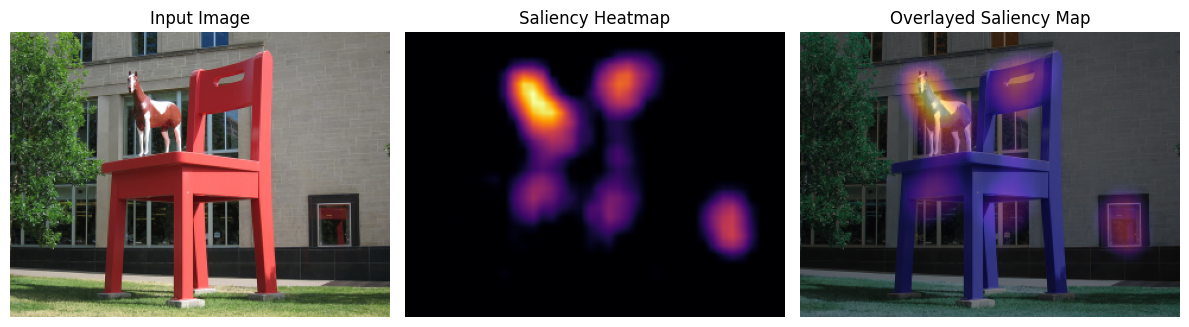

In [10]:
#Visualize predictions on user-specificed image dataset
visualize_predictions(model, generator, num_samples=3, alpha=0.5)

In [11]:
def test_and_visualize_single_image(model, image_path, alpha=0.55):
    """
    Test the model on a single given image and visualize the result.
    """
    
    model.eval()
    
    #Read + preprocess the image
    original_image = cv2.imread(image_path)
    preprocessed_image = img_padding(original_image, shape_r=row, shape_c=col, channels=3).astype('float')
    preprocessed_image = preprocessed_image[..., ::-1] / 255.0  # Convert to RGB and normalize
    preprocessed_image = np.rollaxis(preprocessed_image, 2, 0)  # Convert to PyTorch format (C, H, W)
    
    #Convert to torch tensor and add batch dimension
    input_tensor = torch.tensor(preprocessed_image, dtype=torch.float32).unsqueeze(0).to(device)
    
    ######## PREDICTION #########
    with torch.no_grad():
        prediction = model(input_tensor).cpu().numpy()[0, 0]
    
    #Normalize prediction to visualize
    prediction_resized=cv2.resize(prediction, (original_image.shape[1], original_image.shape[0]))
    prediction_normalized=(prediction_resized-np.min(prediction_resized)) / (np.max(prediction_resized)+1e-8)
    
    #Get Saliency Map
    saliency_map = plt.cm.inferno(prediction_normalized)[..., :3]
    blended_image = (alpha*saliency_map + (1-alpha)*(original_image/255)).clip(0, 1)
    
    #### PLOTTING #########
    plt.figure(figsize=(12, 6))
    #####Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[..., ::-1])  # Convert BGR to RGB
    plt.title("Original Image")
    plt.axis("off")
    
    #######Saliency Map
    plt.subplot(1, 3, 2)
    plt.imshow(prediction_normalized, cmap="inferno")
    plt.title("Saliency Heatmap")
    plt.axis("off")
    
    ########Overlay of Saliency map on Input image
    plt.subplot(1, 3, 3)
    plt.imshow(blended_image)
    plt.title("Overlayed Saliency Map")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


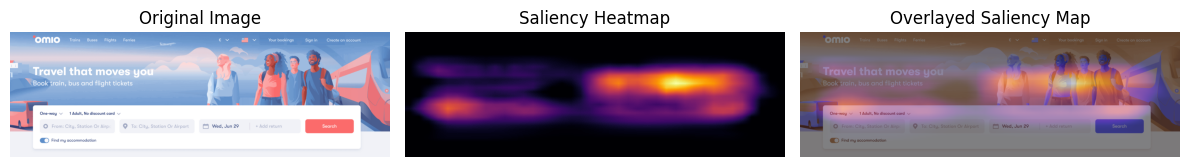

In [12]:
test_image_path = "/kaggle/input/mydataset/2.png"
test_and_visualize_single_image(model, test_image_path, alpha=0.5)

In [13]:
alpha=0.55
######### RUNS THE PREDICTION PIPELINE HERE ##########
def predict_saliency(image):
    # print(type(image))    #it will be a PIL input image at this point

    model.eval()
    
    #Read + preprocess the image
    original_image = np.array(image)   #RGB format
    original_image=original_image[...,::-1]  #changing from RGB to BGR
    preprocessed_image=img_padding(original_image, shape_r=row, shape_c=col, channels=3).astype('float')
    preprocessed_image=preprocessed_image[..., ::-1] / 255.0  # Convert to RGB and normalize
    preprocessed_image=np.rollaxis(preprocessed_image, 2, 0)  # Convert to PyTorch format (C, H, W)
    
    #Convert to torch tensor and add batch dimension
    input_tensor=torch.tensor(preprocessed_image, dtype=torch.float32).unsqueeze(0).to(device)
    
    ######## PREDICTION #########
    with torch.no_grad():
        prediction = model(input_tensor).cpu().numpy()[0, 0]

    #Normalize prediction to visualize
    prediction=cv2.resize(prediction,(original_image.shape[1],original_image.shape[0]))
    prediction=(prediction-np.min(prediction)) / (np.max(prediction)+1e-8)

    #Get Saliency heatmap + overlay
    saliency_map=plt.cm.inferno(prediction)[..., :3]
    blended_image=(alpha*saliency_map + (1-alpha)*(original_image/255)).clip(0, 1)
    
    ###### Converting these imgs to be compatible with PIL+Gradio Interface ######

    saliency_heatmap_image=Image.fromarray((saliency_map*255).astype(np.uint8))
    overlay_image=Image.fromarray((blended_image*255).astype(np.uint8))

    return saliency_heatmap_image,overlay_image


#Gradio Interface definition
interface = gr.Interface(
    fn=predict_saliency,
    inputs=gr.Image(type="pil", label="Input Image"),
    outputs=[
        gr.Image(type="pil", label="Saliency Heatmap"),
        gr.Image(type="pil", label="Overlayed Saliency Map on Input")
    ],
    title="Saliency Prediction",
    description="Hello. Upload an image to get its saliency heatmap and its overlay on Input Image."
)

########## Launch the interface #########
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9bddb2049e43098855.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
